In [14]:
import cv2
import torch
import string
import pathlib
import numpy as np
import pandas as pd

from typing import List
from predict import predict_img

from unet.model import UNet
from utils.rgb import rgb2mask
from utils.dataset import Dataset
from utils.plots import plot_img_and_mask

## Variables

In [6]:
patch_size = 768

## Util Functions

In [19]:
def create_mask_image(bbox_list, width, height):
    image = np.zeros((width, height, 1), np.uint8)
    for box in bbox_list:
        x, y, w, h = box
        cv2.rectangle(image, (x, y), (x + w, y + h), (255), -1)
    return image

def retrieve_bounding_boxes(input_image):
    count, hierarchy = cv2.findContours(input_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    bounding_boxes: List = []
    for contours in count:
        x, y, w, h = cv2.boundingRect(contours)
        if (w * h > 40):
            bounding_boxes.append([x, y, w, h])
    return bounding_boxes, len(bounding_boxes)

def preload_image_data(data_dir: string, img_dir: string):
    dataset_files: List = []
    with open(pathlib.Path(data_dir, 'test_dataset.txt'), mode='r', encoding='utf-8') as file:
        for i, line in enumerate(file):
            path = pathlib.Path(data_dir, img_dir, line.strip(), f'Image/{line.strip()}.png')

            # Load image
            img = cv2.imread(str(path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = Dataset._resize_and_pad(img, (patch_size, patch_size), (0, 0, 0))    
            dataset_files.append(img)
    return dataset_files


## Model prediction

[PREDICTION]: Loading model checkpoints/silvery-serenity-371/checkpoint.pth.tar
[PREDICTION]: Model loaded!


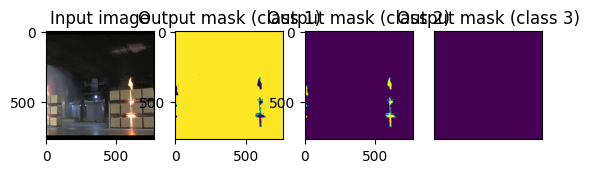

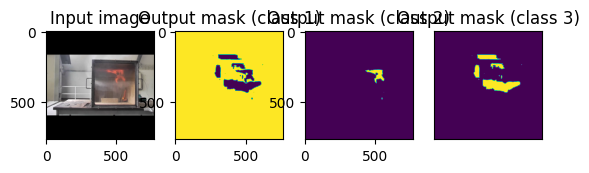

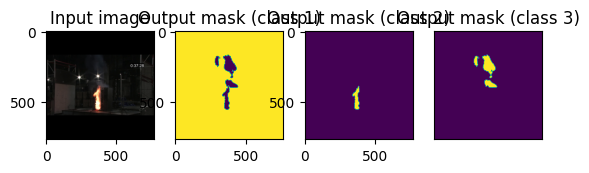

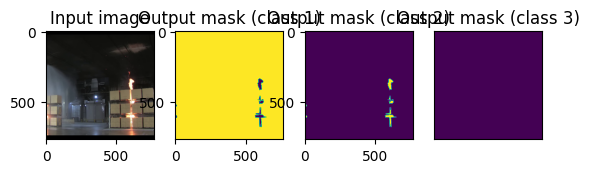

In [20]:
test_data = preload_image_data(r'data', r'imgs')
model_name = r'checkpoints/silvery-serenity-371/checkpoint.pth.tar'

print(f'[PREDICTION]: Loading model {model_name}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = UNet(n_channels=3, n_classes=3).to(device=device)

state_dict = torch.load(model_name, map_location=device)
net.load_state_dict(state_dict['model_state'])
print('[PREDICTION]: Model loaded!')

for i in range(4):
    mask = predict_img(net=net, full_img=test_data[i], device=device)
    plot_img_and_mask(test_data[i], mask)